In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import geopandas as gpd
from shapely import wkt
# from sklearn.cluster import KMeans
from pyproj import Transformer
dir_path = "../LaDe/"

In [2]:
# macro_five_cities = pd.read_pickle(dir_path+"data_with_trajectory_20s/delivery_five_cities.pkl.xz",compression="xz")


In [3]:
road_details = pd.read_csv(dir_path+"road-network/roads.csv",sep="\t")


In [4]:
# macro_five_cities_test = macro_five_cities[macro_five_cities["from_city_name"]=="重庆市"]
road_details_cq = road_details[road_details["city"]=="重庆市"]

In [5]:
delivery_cq = pd.read_csv(dir_path+"delivery/delivery_cq.csv")


In [6]:
group_keys = ["city", "aoi_id"]

aoi_summary = (
    delivery_cq
    .groupby(group_keys)
    .agg(
        lat=("lat", "mean"),
        lng=("lng", "mean"),
        n_deliveries=("aoi_id", "size"),
        aoi_type=("aoi_type", "first")
    )
    .reset_index()
)


In [7]:
delivery_cq["accept_dt"] = pd.to_datetime(
    "2020-" + delivery_cq["accept_gps_time"],
    format="%Y-%m-%d %H:%M:%S"
)

delivery_cq["delivery_dt"] = pd.to_datetime(
    "2020-" + delivery_cq["delivery_gps_time"],
    format="%Y-%m-%d %H:%M:%S"
)

In [8]:
mask = delivery_cq["delivery_dt"] < delivery_cq["accept_dt"]

delivery_cq.loc[mask, "delivery_dt"] += pd.DateOffset(years=1)

In [9]:
delivery_cq["duration_s"] = (
    delivery_cq["delivery_dt"] - delivery_cq["accept_dt"]
).dt.total_seconds()

In [10]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371000  # meters
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    return 2 * R * np.arcsin(np.sqrt(a))



In [11]:
delivery_cq["dist_m"] = haversine(
    delivery_cq["accept_gps_lat"],
    delivery_cq["accept_gps_lng"],
    delivery_cq["delivery_gps_lat"],
    delivery_cq["delivery_gps_lng"]
)

In [12]:
delivery_cq = delivery_cq[
    (delivery_cq["dist_m"] > 0) &
    (delivery_cq["dist_m"] < 50_000)  # < 50 km
]

delivery_cq = delivery_cq[
    (delivery_cq["duration_s"] > 0) &
    (delivery_cq["duration_s"] < 3 * 24 * 3600)  # < 3 days
]

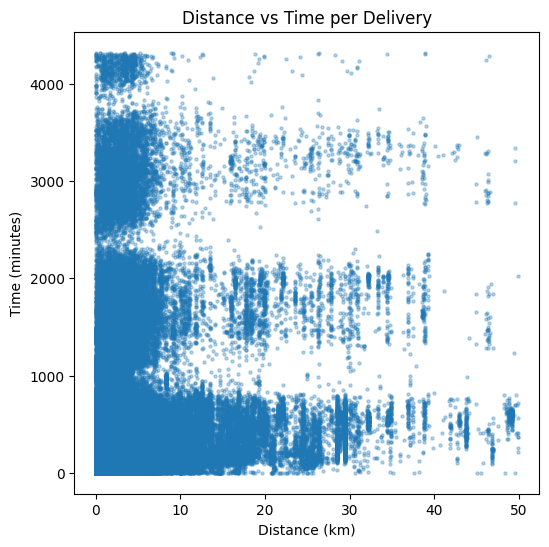

In [13]:
plt.figure(figsize=(6, 6))
plt.scatter(
    delivery_cq["dist_m"] / 1000,         # km
    delivery_cq["duration_s"] / 60,      # minutes
    s=5,
    alpha=0.3
)
plt.ylabel("Time (minutes)")
plt.xlabel("Distance (km)")
plt.title("Distance vs Time per Delivery")
plt.show()

In [14]:
delivery_cq["speed_kmph"] = (
    delivery_cq["dist_m"] / 1000
) / (delivery_cq["duration_s"] / 3600)

active = delivery_cq[
    (delivery_cq["speed_kmph"] > 3) &    # walking+
    (delivery_cq["speed_kmph"] < 40) &   # no teleporting
    (delivery_cq["duration_s"] < 2 * 3600)  # < 2 hours
]


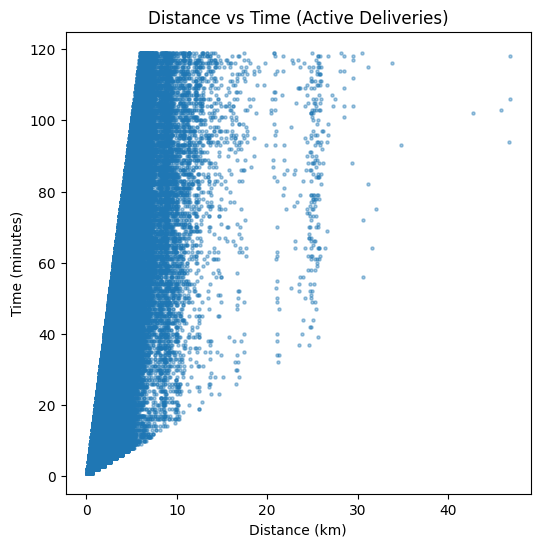

In [15]:


plt.figure(figsize=(6,6))
plt.scatter(
    active["dist_m"] / 1000,
    active["duration_s"] / 60,
    s=5,
    alpha=0.4
)
plt.xlabel("Distance (km)")
plt.ylabel("Time (minutes)")
plt.title("Distance vs Time (Active Deliveries)")
plt.show()


# Analysis of graph 
- Visualizing and filtering quick deliveries. It minimizes the wait time, which gives better approximation for speed = (distance/time)

In [16]:
aoi_centroids = (
    delivery_cq
    .groupby(["city", "aoi_id"])
    .agg(
        aoi_lat=("lat", "mean"),
        aoi_lng=("lng", "mean"),
        n_deliveries=("lat", "size"),
        aoi_type=("aoi_type", "first")
    )
    .reset_index()
)

aoi_centroids = aoi_centroids[aoi_centroids["n_deliveries"] >= 10]


In [17]:
delivery_with_aoi = delivery_cq.merge(
    aoi_centroids[["city", "aoi_id", "aoi_lat", "aoi_lng"]],
    on=["city", "aoi_id"],
    how="inner"
)

In [18]:
aoi_centroids_active = (
    active
    .groupby(["city", "aoi_id"])
    .agg(
        aoi_lat=("lat", "mean"),
        aoi_lng=("lng", "mean"),
        n_deliveries=("lat", "size"),
        aoi_type=("aoi_type", "first")
    )
    .reset_index()
)
aoi_centroids_active = aoi_centroids_active[aoi_centroids_active["n_deliveries"] >= 10]

In [19]:
active_with_aoi = active.merge(
    aoi_centroids_active[["city", "aoi_id", "aoi_lat", "aoi_lng"]],
    on=["city", "aoi_id"],
    how="inner"
)

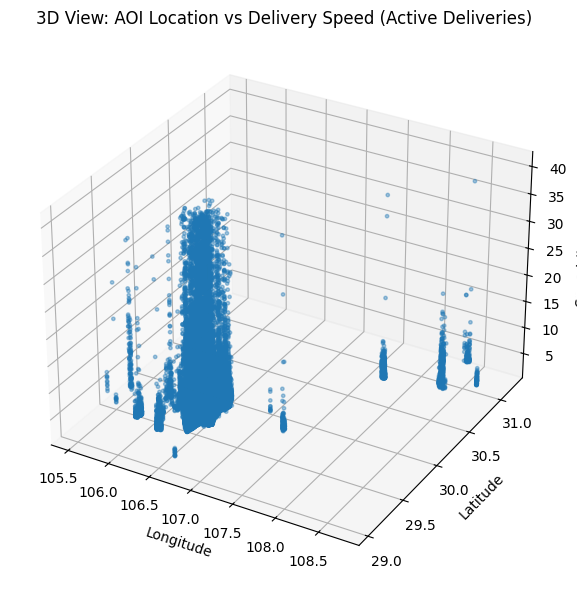

In [20]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(
    active_with_aoi["aoi_lng"],
    active_with_aoi["aoi_lat"],
    active_with_aoi["speed_kmph"],
    s=6,
    alpha=0.4
)

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_zlabel("Speed (km/h)")
ax.set_title("3D View: AOI Location vs Delivery Speed (Active Deliveries)")

plt.tight_layout()
plt.show()

# Speed Analysis in different areas 

In [21]:
road_details_cq["geometry"] = road_details_cq["geometry"].apply(wkt.loads)

road_details_cq = gpd.GeoDataFrame(
    road_details_cq,
    geometry="geometry"
)


C:\Users\saran\AppData\Local\Temp\ipykernel_15320\3587246453.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  road_details_cq["geometry"] = road_details_cq["geometry"].apply(wkt.loads)


In [22]:
road_details_cq = road_details_cq.set_crs(epsg=3857)

In [23]:
road_details_cq.total_bounds

array([11722830.69524315,  3269990.21521534, 12264436.52732865,
        3787845.29867867])

In [24]:
delivery_gdf = gpd.GeoDataFrame(
    active_with_aoi,
    geometry=gpd.points_from_xy(
        active_with_aoi["delivery_gps_lng"],
        active_with_aoi["delivery_gps_lat"]
    ),
    crs="EPSG:4326"   # WGS84
)


In [25]:
delivery_gdf = delivery_gdf.to_crs(road_details_cq.crs)


In [26]:
delivery_gdf.total_bounds

array([11746635.26997947,  3379771.74876148, 13365143.85566502,
        3663023.60979357])

In [27]:
delivery_with_road = gpd.sjoin_nearest(
    delivery_gdf,
    road_details_cq,
    how="left",
    distance_col="dist_to_road_m"
)

In [28]:
delivery_with_road = delivery_with_road[
    delivery_with_road["dist_to_road_m"] < 50
]

In [29]:
delivery_with_road["osm_id"].isna().mean()


np.float64(0.0)

In [30]:
delivery_with_road["dist_to_road_m"].describe()

count    40334.000000
mean        20.206708
std         14.544185
min          0.000263
25%          6.984267
50%         17.988547
75%         31.969202
max         49.998560
Name: dist_to_road_m, dtype: float64

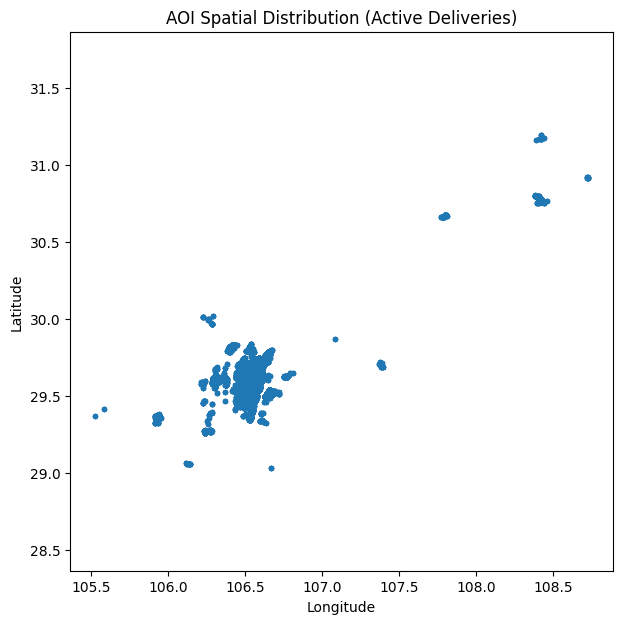

In [31]:

plt.figure(figsize=(7, 7))
plt.scatter(
    active_with_aoi["aoi_lng"],
    active_with_aoi["aoi_lat"],
    s=8,
    alpha=0.5
)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("AOI Spatial Distribution (Active Deliveries)")
plt.axis("equal")  # important for geographic correctness
plt.show()

# Next Step: Cluster the datapoints. Obtain candidate coordinates from each cluster to fetch weather

In [32]:
aoi_points = (
    active_with_aoi
    [["aoi_id", "aoi_lat", "aoi_lng"]]
    .drop_duplicates()
    .reset_index(drop=True)
)

len(aoi_points)


1851

In [33]:
transformer = Transformer.from_crs(
    "EPSG:4326", "EPSG:3857", always_xy=True
)

x, y = transformer.transform(
    aoi_points["aoi_lng"].values,
    aoi_points["aoi_lat"].values
)

aoi_points["x"] = x
aoi_points["y"] = y

In [34]:
GRID_SIZE = 40_000  # meters
aoi_points["grid_x"] = (aoi_points["x"] // GRID_SIZE).astype(int)
aoi_points["grid_y"] = (aoi_points["y"] // GRID_SIZE).astype(int)

aoi_points["weather_cluster"] = (
    aoi_points["grid_x"].astype(str) + "_" +
    aoi_points["grid_y"].astype(str)
)

In [35]:
aoi_points["weather_cluster"].nunique()

18

In [36]:
aoi_cluster_map = aoi_points[["aoi_id", "weather_cluster"]]
active_with_aoi = active_with_aoi.merge(
    aoi_cluster_map,
    on="aoi_id",
    how="left"
)




In [37]:
weather_keys = (
    active_with_aoi
    .assign(
        date=lambda df: df["accept_dt"].dt.date,
        hour=lambda df: df["accept_dt"].dt.hour
    )
    [["weather_cluster", "date", "hour"]]
    .drop_duplicates()
    .reset_index(drop=True)
)



In [38]:
# active_with_aoi["weather_cluster"].nunique()
# active_with_aoi.groupby("weather_cluster").size().sort_values()
cluster_centroids = (
    aoi_points
    .groupby("weather_cluster")
    .agg(
        x=("x", "mean"),
        y=("y", "mean"),
        n_aois=("aoi_id", "count")
    )
    .reset_index()
)


In [39]:
transformer = Transformer.from_crs(
    "EPSG:3857", "EPSG:4326", always_xy=True
)

lng, lat = transformer.transform(
    cluster_centroids["x"].values,
    cluster_centroids["y"].values
)

cluster_centroids["lat"] = lat
cluster_centroids["lng"] = lng

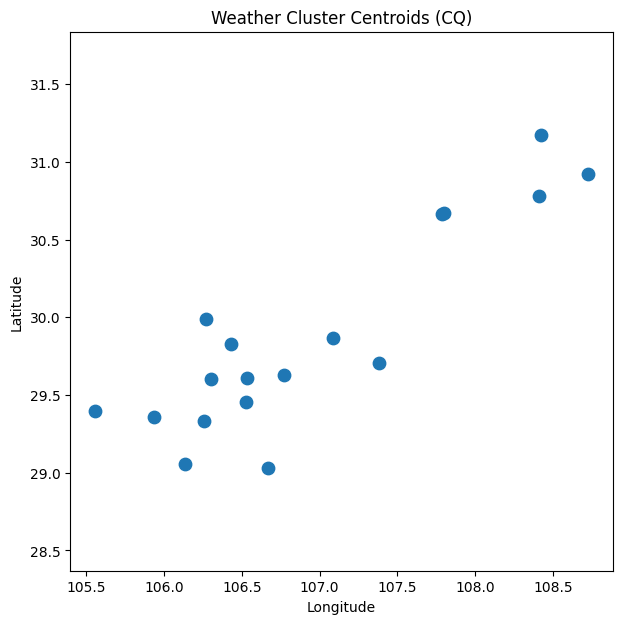

In [40]:
plt.figure(figsize=(7,7))
plt.scatter(
    cluster_centroids["lng"],
    cluster_centroids["lat"],
    s=80
)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Weather Cluster Centroids (CQ)")
plt.axis("equal")
plt.show()

# Centroids after clustering
- Chongqing is divided into 18 regions. Next step to get weather for these 18 regions that will be a good approximation for nearby regions

In [41]:
weather_keys = weather_keys.merge(
    cluster_centroids[["weather_cluster", "lat", "lng"]],
    on="weather_cluster",
    how="left"
)

In [42]:
min_date = active_with_aoi["accept_dt"].dt.date.min()
max_date = active_with_aoi["accept_dt"].dt.date.max()

min_date, max_date


(datetime.date(2020, 5, 1), datetime.date(2020, 10, 31))

In [43]:
import sys
!{sys.executable} -m pip install requests



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [44]:
import requests

def fetch_weather_open_meteo_range(lat, lng, start_date, end_date):
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": lat,
        "longitude": lng,
        "start_date": str(start_date),
        "end_date": str(end_date),
        "hourly": "temperature_2m,precipitation,wind_speed_10m",
        "timezone": "Asia/Shanghai"
    }
    r = requests.get(url, params=params, timeout=60)
    r.raise_for_status()
    return r.json()


In [45]:
weather_rows = []

for _, row in cluster_centroids.iterrows():
    cluster = row["weather_cluster"]
    lat = row["lat"]
    lng = row["lng"]

    data = fetch_weather_open_meteo_range(
        lat, lng, min_date, max_date
    )

    hourly = data["hourly"]
    times = hourly["time"]

    for i, ts in enumerate(times):
        dt = pd.to_datetime(ts)

        weather_rows.append({
            "weather_cluster": cluster,
            "date": dt.date(),
            "hour": dt.hour,
            "temperature": hourly["temperature_2m"][i],
            "rain": hourly["precipitation"][i],
            "wind_speed": hourly["wind_speed_10m"][i]
        })


In [46]:
weather_df = pd.DataFrame(weather_rows)
weather_df = weather_df.merge(
    weather_keys,
    on=["weather_cluster", "date", "hour"],
    how="inner"
)



In [49]:
active_with_aoi["date"] = active_with_aoi["accept_dt"].dt.date
active_with_aoi["hour"] = active_with_aoi["accept_dt"].dt.hour

delivery_with_weather = active_with_aoi.merge(
    weather_df,
    on=["weather_cluster", "date", "hour"],
    how="left"
)



In [54]:
# delivery_with_weather["order_id"].is_unique
delivery_with_road["order_id"].is_unique



False

In [55]:
final_gdf = delivery_with_road.merge(
    delivery_with_weather[
        ["order_id", "temperature", "rain", "wind_speed"]
    ],
    on="order_id",
    how="left"
)


In [57]:
oid = final_gdf["order_id"].iloc[0]

final_gdf[final_gdf["order_id"] == oid][
    ["order_id", "osm_id", "temperature", "rain"]
]

,order_id,osm_id,temperature,rain
0,1903859,1050240647,21.6,0.2


In [59]:
df_wkt = final_gdf.copy()
df_wkt["geometry"] = df_wkt["geometry"].astype(str)

df_wkt = pd.DataFrame(df_wkt)

C:\Users\saran\AppData\Local\Temp\ipykernel_15320\254322495.py:2: UserWarning: Geometry column does not contain geometry.
  df_wkt["geometry"] = df_wkt["geometry"].astype(str)
